# Adaptive RAG

----

Adaptive RAG predicts the **complexity of the input question** using a SLM/LLM and selects an appropriate processing workflow accordingly.

- **Very simple question (No Retrieval)**: Generates answers without RAG.
- **Simple question (Single-shot RAG)**: Efficiently generates answers through a single-step search and generation.
- **Complex question (Iterative RAG)**: Provides accurate answers to complex questions through repeated multi-step search and generation.


Adaptive-RAG, Self-RAG, and Corrective RAG are similar approach, but they have different focuses.

- **Adaptive-RAG**: Dynamically selects appropriate retrieval and generation strategies based on the complexity of the question.
- **Self-RAG**: The model determines the need for retrieval on its own, performs retrieval when necessary, and improves the quality through self-reflection on the generated answers.
- **Corrective RAG**: Evaluates the quality of retrieved documents, and performs additional retrievals such as web searches to supplement the information if the reliability is low.

**Reference**

- [Adaptive-RAG paper](https://arxiv.org/abs/2403.14403)  

In [24]:
import asyncio
import json
import logging
import os
from collections.abc import Awaitable, Callable
from enum import Enum
from typing import Annotated, Any, ClassVar

from azure.core.credentials import AzureKeyCredential
from azure.identity import DefaultAzureCredential
from azure.search.documents import SearchClient
from azure.search.documents.models import VectorizableTextQuery

from dotenv import load_dotenv
from pydantic import BaseModel, Field

from semantic_kernel import Kernel
from semantic_kernel.agents import (
    AssistantAgentThread,
    AzureAIAgent,
    AzureAIAgentSettings,
    AzureAIAgentThread,
    AzureResponsesAgent,
    ChatCompletionAgent,
    ChatHistoryAgentThread,
    ResponsesAgentThread,
)
from semantic_kernel.agents.group_chat.agent_group_chat import AgentGroupChat
from semantic_kernel.agents.strategies.termination.termination_strategy import TerminationStrategy
from semantic_kernel.connectors.ai import FunctionChoiceBehavior
from semantic_kernel.connectors.ai.open_ai import (
    AzureChatCompletion,
    AzureTextEmbedding,
    OpenAIEmbeddingPromptExecutionSettings,
)
from semantic_kernel.connectors.memory.azure_ai_search import (
    AzureAISearchCollection,
    AzureAISearchStore,
)
from semantic_kernel.connectors.search.bing import BingSearch
from semantic_kernel.contents import ChatHistory
from semantic_kernel.contents.utils.author_role import AuthorRole
from semantic_kernel.data import (
    VectorSearchOptions,
    VectorStoreRecordDataField,
    VectorStoreRecordKeyField,
    VectorStoreRecordVectorField,
    vectorstoremodel,
)
from semantic_kernel.filters import FilterTypes, FunctionInvocationContext
from semantic_kernel.functions import (
    KernelArguments,
    KernelParameterMetadata,
    KernelPlugin,
    kernel_function,
)
from semantic_kernel.kernel_pydantic import KernelBaseSettings, KernelBaseModel
from semantic_kernel.prompt_template import InputVariable, PromptTemplateConfig
from semantic_kernel.processes.kernel_process.kernel_process_step import KernelProcessStep
from semantic_kernel.processes.kernel_process.kernel_process_step_context import KernelProcessStepContext
from semantic_kernel.processes.kernel_process.kernel_process_step_state import KernelProcessStepState
from semantic_kernel.processes.local_runtime.local_event import KernelProcessEvent
from semantic_kernel.processes.local_runtime.local_kernel_process import start
from semantic_kernel.processes.process_builder import ProcessBuilder
from semantic_kernel.processes.process_function_target_builder import ProcessFunctionTargetBuilder
from semantic_kernel.contents.streaming_chat_message_content import StreamingChatMessageContent

from azure.ai.evaluation import (
    GroundednessEvaluator,
    RelevanceEvaluator,
    RetrievalEvaluator,
)

logging.basicConfig(level=logging.WARNING)

kernel = Kernel()

load_dotenv(override=True)

True

In [25]:
# Get the environment variables
azure_ai_search_endpoint = os.getenv("AZURE_AI_SEARCH_ENDPOINT")
azure_search_admin_key = os.getenv("AZURE_AI_SEARCH_API_KEY", "")
index_name = os.getenv("AZURE_SEARCH_INDEX_NAME", "hotels-sample-index")

azure_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_openai_key = (
    os.getenv("AZURE_OPENAI_API_KEY", "")
    if len(os.getenv("AZURE_OPENAI_API_KEY", "")) > 0
    else None
)
azure_openai_chat_deployment_name = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
azure_openai_embedding_deployment_name = os.getenv(
    "AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME", "text-embedding-ada-002"
)
azure_openai_api_version = os.getenv("AZURE_OPENAI_API_VERSION", "2024-06-01")

model_config = {
    "azure_endpoint": azure_openai_endpoint,
    "api_key": azure_openai_key,
    "azure_deployment": azure_openai_chat_deployment_name,
    "api_version": azure_openai_api_version,
    "type": "azure_openai",
}

embedding_model_config = {
    "azure_endpoint": azure_openai_endpoint,
    "api_key": azure_openai_key,
    "azure_deployment": azure_openai_embedding_deployment_name,
    "api_version": azure_openai_api_version,
    "type": "azure_openai",
}

## 🧪 Step 1. Test and Construct each module
---

Before building the entire the graph pipeline, we will test and construct each module separately.

- **IntentRouter**
- **SearchClient(Retrieval)**
- **Retrieval Grader**
- **Question Re-writer**
- **Answer Generator**
- **Groundedness Evaluator**
- **Relevance Evaluator**
- **Keyword Re-writer**
- **Web Search Tool**


### Define your LLM

This hands-on only uses the `gpt-4o-mini`, but you can utilize multiple models in the pipeline.

In [26]:
service_id = "adaptive-rag"
kernel.add_service(
    AzureChatCompletion(
        service_id=service_id,
        # api_key=os.getenv("AZURE_OPENAI_API_KEY"),
        # endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
        # deployment_name=os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"),
        # api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
        # credential=DefaultAzureCredential()
    )
)

### Intent Router

Construct a `intent_router` agent to analyze the intent from user's query to route the query to the appropriate module.

In [27]:
from pydantic import BaseModel, Field
from typing import List
from enum import Enum

class IntentType(str, Enum):
    LLM = "LLM"
    RAG = "RAG"
    websearch = "websearch"    

class IntentResponse(BaseModel):
    intent_type: IntentType = Field(..., description="Processing status")

In [28]:
if kernel.services.get("adaptive-rag") is None:
    service_id = "adaptive-rag"
    kernel.add_service(
        AzureChatCompletion(
            service_id=service_id,
        ),
    )

req_settings = kernel.get_prompt_execution_settings_from_service_id(service_id=service_id)
req_settings.max_tokens = 2000
req_settings.temperature = 0.7
req_settings.response_format = IntentResponse

#query="how are you today?"
query="Can you recommend a few hotels with complimentary breakfast?"
#query="Can you recommend the newest Openings Hotels in Manhattan Midtown 2025?"

# This prompt provides instructions to the model
INTENT_ROUTER_PROMPT="""
You are an expert at routing a user question to LLM or RAG or websearch.
                    The LLM covers casual topic such as greeting, small talks.
                    Use the LLM for questions on casual topics.
                    The RAG contains documents related to hotel information in New York until Aug, 2024.
                    Use the RAG for questions on the hotel related topics. For all else, websearch.
                    response inent_type such as LLM, RAG, or websearch.
Query: {{$query}}
"""


prompt_template_config = PromptTemplateConfig(
    template=INTENT_ROUTER_PROMPT,
    name="intentRouter",
    template_format="semantic-kernel",
    input_variables=[
        InputVariable(name="query", description="The user input", is_required=True),
    ],
    execution_settings=req_settings,
)

intent_router = kernel.add_function(
    function_name="intentRouterFunc",
    plugin_name="intentRouterPlugin",
    prompt_template_config=prompt_template_config,
)

response = await kernel.invoke(intent_router, query=query)
print(response)

response_json = json.loads(response.value[0].items[0].text)
print(response_json["intent_type"])


{"intent_type":"RAG"}
RAG


### Construct Retrieval Chain based on PDF
- We use the hotels-sample-index, which can be created in minutes and runs on any search service tier. This index is created by a wizard using built-in sample data.

In [29]:
azure_ai_search_endpoint = os.getenv("AZURE_AI_SEARCH_ENDPOINT")
azure_search_admin_key = os.getenv("AZURE_AI_SEARCH_API_KEY", "")
search_client = SearchClient(
    endpoint=azure_ai_search_endpoint,
    index_name=index_name,
    credential=AzureKeyCredential(azure_search_admin_key),
    semantic_configuration_name="my-semantic-config",
)

# Query is the question being asked. It's sent to the search engine and the LLM.
query = "Can you recommend a few hotels with complimentary breakfast?"

fields = "descriptionVector"  # TODO: Check if this is the correct field name
# don't use exhaustive search for large indexes
vector_query = VectorizableTextQuery(
    text=query, k_nearest_neighbors=2, fields=fields, exhaustive=True
)

# Search results are created by the search client.
# Search results are composed of the top 3 results and the fields selected from the search index.
# Search results include the top 3 matches to your query.
search_results = search_client.search(
    search_text=query,
    vector_queries=[vector_query],
    select="Description,HotelName,Tags",
    top=3,
)
sources_formatted = "\n".join(
    [
        f'{document["HotelName"]}:{document["Description"]}:{document["Tags"]}'
        for document in search_results
    ]
)

print(sources_formatted)

Friendly Motor Inn:Close to historic sites, local attractions, and urban parks. Free Shuttle to the airport and casinos. Free breakfast and WiFi.:['24-hour front desk service', 'continental breakfast', 'free wifi']
Lion's Den Inn:Full breakfast buffet for 2 for only $1. Excited to show off our room upgrades, faster high speed WiFi, updated corridors & meeting space. Come relax and enjoy your stay.:['laundry service', 'free wifi', 'restaurant']
Starlight Suites:Complimentary Airport Shuttle & WiFi. Book Now and save - Spacious All Suite Hotel, Indoor Outdoor Pool, Fitness Center, Florida Green certified, Complimentary Coffee, HDTV:['pool', 'coffee in lobby', 'free wifi']


### Semantic Kernel Vector Store

This hands-on only uses Vector Store as a memory connector and a simple function that uses the add_vector_to_records function to add vectors

In [30]:
###
# The data model used for this sample is based on the hotel data model from the Azure AI Search samples.
# When deploying a new index in Azure AI Search using the import wizard you can choose to deploy the 'hotel-samples'
# dataset, see here: https://learn.microsoft.com/en-us/azure/search/search-get-started-portal.
# This is the dataset used in this sample with some modifications.
# This model adds vectors for the 2 descriptions in English and French.
# Both are based on the 1536 dimensions of the OpenAI models.
# You can adjust this at creation time and then make the change below as well.
# This sample assumes the index is deployed, the vector fields can be empty.
# If the vector fields are empty, change the first_run parameter to True to add the vectors.
###

@vectorstoremodel
class HotelSampleClass(BaseModel):
    HotelId: Annotated[str, VectorStoreRecordKeyField]
    HotelName: Annotated[str | None, VectorStoreRecordDataField()] = None
    Description: Annotated[
        str,
        VectorStoreRecordDataField(
            has_embedding=True, embedding_property_name="DescriptionVector", is_full_text_searchable=True
        ),
    ]
    DescriptionVector: Annotated[
        list[float] | None,
        VectorStoreRecordVectorField(
            dimensions=1536,
            local_embedding=True,
            embedding_settings={"embedding": OpenAIEmbeddingPromptExecutionSettings(dimensions=1536)},
        ),
    ] = None
    Description_kr: Annotated[
        str, VectorStoreRecordDataField(has_embedding=True, embedding_property_name="descriptionKOVector")
    ]
    descriptionKOVector: Annotated[
        list[float] | None,
        VectorStoreRecordVectorField(
            dimensions=1536,
            local_embedding=True,
            embedding_settings={"embedding": OpenAIEmbeddingPromptExecutionSettings(dimensions=1536)},
        ),
    ] = None
    Category: Annotated[str, VectorStoreRecordDataField()]
    Tags: Annotated[list[str], VectorStoreRecordDataField()]
    ParkingIncluded: Annotated[bool | None, VectorStoreRecordDataField()] = None
    LastRenovationDate: Annotated[str | None, VectorStoreRecordDataField()] = None
    Rating: Annotated[float, VectorStoreRecordDataField()]
    Location: Annotated[dict[str, Any], VectorStoreRecordDataField()]
    Address: Annotated[dict[str, str | None], VectorStoreRecordDataField()]
    Rooms: Annotated[list[dict[str, Any]], VectorStoreRecordDataField()]
    


In [31]:
query = "Can you recommend a few hotels with complimentary breakfast?"

COLLECTION_NAME = os.getenv("AZURE_SEARCH_INDEX_NAME", "hotels-sample-index")
kernel = Kernel()
# Add the OpenAI text embedding service

embeddings = AzureTextEmbedding(
    service_id="embedding", 
    deployment_name=azure_openai_embedding_deployment_name,
    endpoint=azure_openai_endpoint,
    api_key=azure_openai_key,
    )
kernel.add_service(embeddings)
# Create the Azure AI Search collection
collection = AzureAISearchCollection[str, HotelSampleClass](
    collection_name=COLLECTION_NAME, data_model_type=HotelSampleClass
)

# Search using just text, by default this will search all the searchable text fields in the index.
results = await collection.text_search(search_text=query)
print("Search results using text: ")
async for result in results.results:
    print(
        f"    {result.record.HotelId} (in {result.record.Address['City']}, "
        f"{result.record.Address['Country']}): {result.record.Description} (score: {result.score})"
    )

print("\n")

# Generate the vector for the query
query_vector = (await embeddings.generate_raw_embeddings([query]))[0]

print("Search results using vector: ")
# Use vectorized search to search using the vector.
results = await collection.vectorized_search(
    vector=query_vector,
    options=VectorSearchOptions(vector_field_name="descriptionVector"),
)
async for result in results.results:
    print(
        f"    {result.record.HotelId} (in {result.record.Address['City']}, "
        f"{result.record.Address['Country']}): {result.record.Description} (score: {result.score})"
    )

# Delete the collection object so that the connection is closed.
del collection

Search results using text: 


    27 (in Aventura, USA): Complimentary Airport Shuttle & WiFi. Book Now and save - Spacious All Suite Hotel, Indoor Outdoor Pool, Fitness Center, Florida Green certified, Complimentary Coffee, HDTV (score: 4.735675)
    16 (in Seattle, USA): 5 star Luxury Hotel - Biggest Rooms in the city. #1 Hotel in the area listed by Traveler magazine. Free WiFi, Flexible check in/out, Fitness Center & espresso in room. (score: 4.458799)
    40 (in Scottsdale, USA): Only 8 miles from Downtown. On-site bar/restaurant, Free hot breakfast buffet, Free wireless internet, All non-smoking hotel. Only 15 miles from airport. (score: 3.9828727)


Search results using vector: 
    44 (in Lexington, USA): Close to historic sites, local attractions, and urban parks. Free Shuttle to the airport and casinos. Free breakfast and WiFi. (score: 0.6665876)
    22 (in Redmond, USA): Full breakfast buffet for 2 for only $1. Excited to show off our room upgrades, faster high speed WiFi, updated corridors & meeting spac

### Question-Retrieval Grader

Construct a retrieval grader that evaluates the relevance of the retrieved documents to the input question. The retrieval grader should take the input question and the retrieved documents as input and output a relevance score for each document.<br>
Note that the retrieval grader should be able to handle **multiple documents** as input.

In [32]:
retrieval_eval = RetrievalEvaluator(model_config)

query_response = dict(query=query, context=sources_formatted)

retrieval_score = retrieval_eval(**query_response)
print(retrieval_score)
retrieval_score["retrieval"]

{'retrieval': 2.0, 'gpt_retrieval': 2.0, 'retrieval_reason': "The input Data should get a Score of 2 because it contains partially relevant context chunks, with the most relevant chunk at the top, but also includes less relevant information and does not fully satisfy the query's request for complimentary breakfast."}


2.0

### Question Re-writer

Construct a `question_rewriter` node to rewrite the question based on the retrieved documents and the generated answer.

In [33]:
if kernel.services.get("adaptive-rag") is None:
    service_id = "adaptive-rag"
    kernel.add_service(
        AzureChatCompletion(
            service_id=service_id,
        ),
    )
    
req_settings = kernel.get_prompt_execution_settings_from_service_id(service_id=service_id)
req_settings.max_tokens = 2000

query = "Can you recommend a few factories with complimentary breakfast?"

# This prompt provides instructions to the model
REWRITE_PROMPT = """
You a question re-writer that converts an input question to a better version that is optimized
for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning based on hotel domain.
Query: {{$query}}
"""

# Send the search results and the query to the LLM to generate a response based on the prompt.
prompt_template_config = PromptTemplateConfig(
    template=REWRITE_PROMPT,
    name="rewrite",
    template_format="semantic-kernel",
    input_variables=[
        InputVariable(name="query", description="The user input", is_required=True)
    ],
    execution_settings=req_settings,
)

rewrite = kernel.add_function(
    function_name="rewriteFunc",
    plugin_name="rewritePlugin",
    prompt_template_config=prompt_template_config,
)


response = await kernel.invoke(rewrite, query=query)
# Here is the response from the chat model.
print(response)

Could you suggest some hotels that offer complimentary breakfast?


### Answer Generator

Construct a LLM Generation node. This is a Naive RAG chain that generates an answer based on the retrieved documents. 

We recommend you to use more advanced RAG chain for production

In [34]:
from pydantic import BaseModel
from typing import List


class HotelInfo(BaseModel):
    hotel_name: str
    description: str


class RecommendationList(BaseModel):
    recommendation: List[HotelInfo]

In [35]:
req_settings = kernel.get_prompt_execution_settings_from_service_id(service_id=service_id)
req_settings.max_tokens = 2000
req_settings.temperature = 0.7
req_settings.response_format = RecommendationList

# This prompt provides instructions to the model
GROUNDED_PROMPT = """
You are a friendly assistant that recommends hotels based on activities and amenities.
Answer the query using only the context provided below in a friendly and concise bulleted manner.
Answer ONLY with the facts listed in the list of context below.
If there isn't enough information below, say you don't know.
Generate a response that includes the top 3 results.
Do not generate answers that don't use the context below.
Query: {{$query}}
Context:\n{{$context}}
"""


prompt_template_config = PromptTemplateConfig(
    template=GROUNDED_PROMPT,
    name="recommendation",
    template_format="semantic-kernel",
    input_variables=[
        InputVariable(name="query", description="The user input", is_required=True),
        InputVariable(name="context", description="Context to recommend hotels", is_required=True),
    ],
    execution_settings=req_settings,
)

recommendation = kernel.add_function(
    function_name="recommendationFunc",
    plugin_name="recommendationPlugin",
    prompt_template_config=prompt_template_config,
)

response = await kernel.invoke(recommendation, query=query, context=sources_formatted)

# Load the response content as a JSON object
response_json = json.loads(response.value[0].items[0].text)

# Print the recommendations
for hotel in response_json["recommendation"]:
    print(f"Hotel Name: {hotel['hotel_name']}")
    print(f"Description: {hotel['description']}")
    print()

Hotel Name: Friendly Motor Inn
Description: Close to historic sites, local attractions, and urban parks. Free breakfast and WiFi.

Hotel Name: Lion's Den Inn
Description: Full breakfast buffet for 2 for only $1. Excited to show off our room upgrades and faster high speed WiFi.

Hotel Name: Starlight Suites
Description: Complimentary Airport Shuttle & WiFi, spacious all-suite hotel with indoor outdoor pool and fitness center.



### Groundedness Evaluator

Construct a `groundedness_grader` node to evaluate the **hallucination** of the generated answer based on the retrieved documents.<br>

`yes` means the answer is relevant to the retrieved documents, and `no` means the answer is not relevant to the retrieved documents.

In [36]:
groundedness_eval = GroundednessEvaluator(model_config)

query_response = dict(query=query, context=sources_formatted, response=response_json)

groundedness_score = groundedness_eval(**query_response)
print(groundedness_score)

{'groundedness': 2.0, 'gpt_groundedness': 2.0, 'groundedness_reason': 'The RESPONSE provides information about hotels with complimentary breakfast but does not address the QUERY about factories, making it only partially relevant. Therefore, it does not meet the criteria for a higher groundedness score.'}


### Relevance Evaluator

Construct a `relevance_grader` node to evaluate the relevance of the generated answer to the question.<br>
`yes` means the answer is relevant to the question, and `no` means the answer is not relevant to the question.

In [37]:
relevance_eval = RelevanceEvaluator(model_config)

query_response = dict(query=query, response=response_json)

relevance_score = relevance_eval(**query_response)
print(relevance_score)

{'relevance': 1.0, 'gpt_relevance': 1.0, 'relevance_reason': 'The RESPONSE does not address the QUERY correctly as it provides information about hotels instead of factories, making it irrelevant to the question asked.'}


### Keyword Re-writer

Construct a `keyword_rewriter` agent to rewrite the question as the search keyword.

In [38]:
query="Can you recommend a few hotels with complimentary breakfast?"

req_settings = kernel.get_prompt_execution_settings_from_service_id(service_id=service_id)
req_settings.max_tokens = 2000
req_settings.temperature = 0.7

# This prompt provides instructions to the model
KEYWORD_REWRITE_PROMPT="""
You a keyword re-writer that converts an input question to a better version that is optimized for search. 
Generate search keyword from a user query 
to be more specific, detailed, and likely to retrieve relevant information, allowing for a more accurate response through web search.
Don't include the additional context from the user question.

Query: {{$query}}
Revised web search query:
"""


prompt_template_config = PromptTemplateConfig(
    template=KEYWORD_REWRITE_PROMPT,
    name="keywordRewrite",
    template_format="semantic-kernel",
    input_variables=[
        InputVariable(name="query", description="The user input", is_required=True)
    ],
    execution_settings=req_settings,
)

recommendation = kernel.add_function(
    function_name="keywordRewriteFunc",
    plugin_name="keywordRewritePlugin",
    prompt_template_config=prompt_template_config,
)

response = await kernel.invoke(recommendation, query=query, context=sources_formatted)



# Here is the response from the chat model.
print(response)

Best hotels with complimentary breakfast options in [specific location or city] 


### Web Search Tool (azure_genai_utils vs semantic_kernel.connectors.BingSearch)

Web search tool is used to enhance the context. <br>

It is used when all the documents do not meet the relevance threshold or the evaluator is not confident.

In [39]:
import azure_genai_utils.tools 

WEB_SEARCH_FORMAT_OUTPUT = False

web_search_tool = azure_genai_utils.tools.BingSearch(
    max_results=3,
    locale="en-US",
    include_news=False,
    include_entity=False,
    format_output=WEB_SEARCH_FORMAT_OUTPUT,
)

In [40]:
query = "Newest Openings Hotels in NYC 2024 2025?"
results = web_search_tool.invoke({"query": query})
print(results[0].get("content", "No content"))

This page was last updated: 2025-01-31 Best new hotels in NYC (New York City)
- Days Inn New York Chinatown (Dec 2024)
- Four Seasons Hotel (2024)
- Waldorf Astoria (Reopening 2025)
- The Manner (2024) - Aura Hotel Times Square (2024) - The Luxury Collection Hotel (2024) - The Surrey (2024) - SpringHill Suites Manhattan (2024) -
Tru by Hilton
Brooklyn
(2024) -
Warren Street Hotel (2024) - Holiday Inn Express Bronx (2024)﻿... Newest Hotels in New York City 2024 Hotel near Chinatown opened in December 2024 This new Days Inn hotel near Chinatown was opened in December 2024. The
Days Inn
is located on Eldridge Street, offering modern guest accommodations that come with a free breakfast, free Wi-Fi, a
business center, and a fitness center. Read Reviews / Check Prices Luxury 5-star
hotel in Manhattan reopened in late 2024 This top luxury hotel in New York City was reopened in November 2024 after a four-year closure. The
five-star
Four Seasons Hotel New York is located at
57 East 57th Street,

In [41]:
# Simulate a conversation with the agent
USER_INPUTS = [
    "What is today's weather in South Korea?"
]
import semantic_kernel.connectors.search.bing
from semantic_kernel.functions import KernelArguments, KernelParameterMetadata, KernelPlugin

webplugin = KernelPlugin.from_text_search_with_search(
        semantic_kernel.connectors.search.bing.BingSearch(api_key=os.getenv("BING_SUBSCRIPTION_KEY")),
        plugin_name="bing",
        description="Search the web for information.",
        parameters=[
            KernelParameterMetadata(
                name="query",
                description="The search query.",
                type="str",
                is_required=True,
                type_object=str,
            ),
            KernelParameterMetadata(
                name="top",
                description="The number of results to return.",
                type="int",
                is_required=False,
                default_value=1,
                type_object=int,
            ),
            KernelParameterMetadata(
                name="skip",
                description="The number of results to skip.",
                type="int",
                is_required=False,
                default_value=0,
                type_object=int,
            ),
            # KernelParameterMetadata(
            #     name="site",
            #     description="The site to search.",
            #     default_value="https://github.com/microsoft/semantic-kernel/tree/main/python",
            #     type="str",
            #     is_required=False,
            #     type_object=str,
            # ),
        ],
    )



agent = ChatCompletionAgent(
        service=AzureChatCompletion(),
        name="Host",
        instructions="Answer questions from web search results. Add the web search reference url to the answer.",
        plugins=[webplugin],
    )

# 2. Create a thread to hold the conversation
# If no thread is provided, a new thread will be
# created and returned with the initial response
thread: ChatHistoryAgentThread = None

for user_input in USER_INPUTS:
    print(f"# User: {user_input}")
    # 4. Invoke the agent for a response
    response = await agent.get_response(messages=user_input, thread=thread)
    print(f"# {response.name}: {response} ")
    thread = response.thread


########################################
# invoke_stream mode 
########################################
# for user_input in USER_INPUTS:
#         print(f"# User: '{user_input}'")
#         first_chunk = True
#         # 4. Invoke the agent for the current message and print the response
#         async for response in agent.invoke_stream(messages=user_input, thread=thread):
#             thread = response.thread
#             if first_chunk:
#                 print(f"# {response.name}: ", end="", flush=True)
#                 first_chunk = False
#             print(response.content, end="", flush=True)
#         print()

await thread.delete() if thread else None

# User: What is today's weather in South Korea?


# Host: Today's weather in South Korea is generally pleasant, with temperatures around 17°C. In Seoul, specifically, the day will be mostly clear with a maximum temperature of about 16°C and a minimum of around 6°C. As the evening approaches, temperatures are expected to drop to around 10°C (50°F), with some cloudiness later in the night.

For more detailed information, you can check the hourly weather updates. 

Reference URL: [Bing Weather Search](https://www.bing.com/search?q=South+Korea+weather+today) 


<br>

## 🧪 Step 2. Define the Agentic Architecture
- Before building the agentic pipeline, we need to design the message, topic, agent and message routing logic. 
- You should define the terminate condition for the pipeline.

### Message, Topic, Agent Definition

Visualizing the abstract architecture of the pipeline will help you understand the message flow and the agent's role in the pipeline.

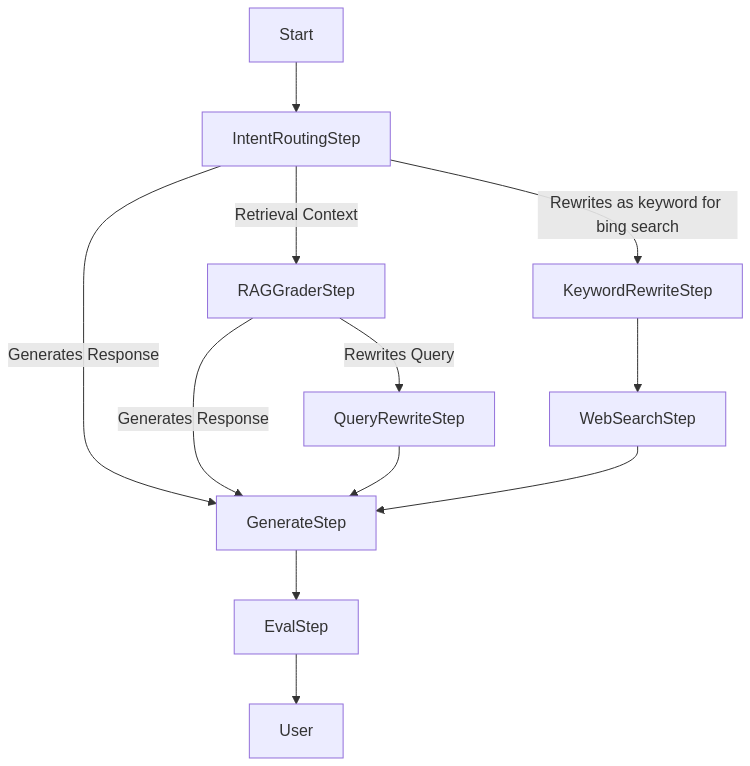

In [42]:
from azure_genai_utils.graphs import visualize_agents

agents = [
    "Start",
    "IntentRoutingStep",
    "RAGGraderStep",
    "QueryRewriteStep",
    "EvalStep",
    "KeywordRewriteStep",
    "WebSearchStep",
    "GenerateStep",
    "User"
]
interactions = [
    ("Start", "IntentRoutingStep"),
    ("IntentRoutingStep", "GenerateStep", "Generates Response"),
    ("IntentRoutingStep", "RAGGraderStep", "Retrieval Context"),
    ("IntentRoutingStep", "KeywordRewriteStep", "Rewrites as keyword for bing search"),
    ("GenerateStep", "EvalStep"),
    ("EvalStep", "User"),
    ("RAGGraderStep", "GenerateStep", "Generates Response"),
    ("RAGGraderStep", "QueryRewriteStep", "Rewrites Query"),
    ("QueryRewriteStep", "GenerateStep"),
    ("KeywordRewriteStep", "WebSearchStep"),
    ("WebSearchStep", "GenerateStep")
    #("EvalAgent", "IntentRouterAgent"),
]

visualize_agents(agents, interactions)

This is an example of visualized pipeline

!["adaptive-RAG"](../../images/SK-adaptive-RAG.png)

In [43]:
# Define the events for the process
class CommonEvents(Enum):
    StartProcess = "StartProcess"
    UserInputReceived = "UserInputReceived"
    Exit = "exit"

class ReflectionEvents(Enum):
    
    LowRAGGrade = "LowRAGGrade"
    RAGGraderDone = "RAGGraderDone"
    KeywordRewriteDone = "KeywordRewriteDone"
    BingSearchDone = "BingSearchDone"
    ResponseGenerated = "ResponseGenerated"
    
    RAGGraderRequested = "RAGGraderRequested"
    BingSearchRequested = "BingSearchRequested"
    GenerateRequested = "GenerateRequested"
    
@vectorstoremodel
class HotelSampleClass(BaseModel):
    HotelId: Annotated[str, VectorStoreRecordKeyField]
    HotelName: Annotated[str | None, VectorStoreRecordDataField()] = None
    Description: Annotated[
        str,
        VectorStoreRecordDataField(
            has_embedding=True, embedding_property_name="DescriptionVector", is_full_text_searchable=True
        ),
    ]
    DescriptionVector: Annotated[
        list[float] | None,
        VectorStoreRecordVectorField(
            dimensions=1536,
            local_embedding=True,
            embedding_settings={"embedding": OpenAIEmbeddingPromptExecutionSettings(dimensions=1536)},
        ),
    ] = None
    Description_kr: Annotated[
        str, VectorStoreRecordDataField(has_embedding=True, embedding_property_name="descriptionKOVector")
    ]
    descriptionKOVector: Annotated[
        list[float] | None,
        VectorStoreRecordVectorField(
            dimensions=1536,
            local_embedding=True,
            embedding_settings={"embedding": OpenAIEmbeddingPromptExecutionSettings(dimensions=1536)},
        ),
    ] = None
    Category: Annotated[str, VectorStoreRecordDataField()]
    Tags: Annotated[list[str], VectorStoreRecordDataField()]
    ParkingIncluded: Annotated[bool | None, VectorStoreRecordDataField()] = None
    LastRenovationDate: Annotated[str | None, VectorStoreRecordDataField()] = None
    Rating: Annotated[float, VectorStoreRecordDataField()]
    Location: Annotated[dict[str, Any], VectorStoreRecordDataField()]
    Address: Annotated[dict[str, str | None], VectorStoreRecordDataField()]
    Rooms: Annotated[list[dict[str, Any]], VectorStoreRecordDataField()]
    


class IntentType(str, Enum):
    LLM = "LLM"
    RAG = "RAG"
    websearch = "websearch"    

class IntentResponse(BaseModel):
    intent_type: IntentType = Field(..., description="Processing status")
    
    

In [44]:
service_id = "adaptive-rag"
import time

class UserInputState(KernelBaseModel):
    user_inputs: list[str] = []
    current_input_index: int = 0

class UserInputStep(KernelProcessStep[UserInputState]):
    GET_USER_INPUT: ClassVar[str] = "get_user_input"

    def create_default_state(self) -> "UserInputState":
        """Creates the default UserInputState."""
        return UserInputState()

    def populate_user_inputs(self):
        """Method to be overridden by the user to populate with custom user messages."""
        pass

    async def activate(self, state: KernelProcessStepState[UserInputState]):
        """Activates the step and sets the state."""
        state.state = state.state or self.create_default_state()
        self.state = state.state
        self.populate_user_inputs()
    
    @kernel_function(name=GET_USER_INPUT)
    async def get_user_input(self, context: KernelProcessStepContext):
        """Gets the user input."""
        if not self.state:
            raise ValueError("State has not been initialized")

        #user_message = input("USER: ")
        # LLM
        # user_message = "I was wondering if you can tell me the history of Microsoft."
        # RAG
        user_message = "Can you recommend a few hotels with complimentary breakfast?"
        # web search
        today = time.strftime("%Y-%m-%d")
        #user_message = f"what is today's breaking news in South Korea ({today})?"
        #user_message = "Tell me about the newest hotels in NYC 2025?"

        
        if "exit" in user_message:
            await context.emit_event(process_event=CommonEvents.Exit, data=None)
            return

        self.state.current_input_index += 1
        
        data = {
            "query": user_message
        }
        
        print(f"{'-'*80}\n{self.GET_USER_INPUT}:\n{user_message}")
        await context.emit_event(process_event=ReflectionEvents.RAGGraderRequested, data=data)
        
class IntentRoutingStep(KernelProcessStep):
    INTENT_ROUTING: ClassVar[str] = "IntentRoutingStep"
    
    @kernel_function(name=INTENT_ROUTING)
    async def do_it(self, context: KernelProcessStepContext, data:dict, kernel: Kernel):
        
        query = data.get("query", "")
        
        req_settings = kernel.get_prompt_execution_settings_from_service_id(service_id=service_id)
        req_settings.max_tokens = 2000
        req_settings.temperature = 0.7
        req_settings.response_format = IntentResponse
        
        # This prompt provides instructions to the model
        INTENT_ROUTER_PROMPT="""
        You are an intelligent intent classifier that determines the best processing route for a user's question. Classify each question into one of the following categories:
        LLM: Use this for casual conversation, greetings, small talk, or general knowledge questions that do not require up-to-date or domain-specific information.
        RAG: Use this for questions related to hotel information, based on documents available up to August 2024.
        websearch: Use this for questions that require the most recent information, or if the topic is not covered by LLM or RAG (e.g., breaking news, current events, or updates after August 2024).
        Your only output should be the intent_type: either LLM, RAG, or websearch.
        Do not explain your reasoning or provide any additional text—only return the intent_type.
        Query: {{$query}}
        """


        prompt_template_config = PromptTemplateConfig(
            template=INTENT_ROUTER_PROMPT,
            name="intentRouter",
            template_format="semantic-kernel",
            input_variables=[
                InputVariable(name="query", description="The user input", is_required=True),
            ],
            execution_settings=req_settings,
        )

        intent_router = kernel.add_function(
            function_name="intentRouterFunc",
            plugin_name="intentRouterPlugin",
            prompt_template_config=prompt_template_config,
        )
        
        print(f"{'-'*80}\n{self.INTENT_ROUTING}:\n{query}")
        
        response = await kernel.invoke(intent_router, query=query)
        print(response)
        response_json = json.loads(response.value[0].items[0].text)
        
        data = {
            "query": query,
            "intent": response_json["intent_type"]
        }
        
        if response_json["intent_type"] == "RAG":
            await context.emit_event(process_event=ReflectionEvents.RAGGraderRequested, data=data)
        elif response_json["intent_type"] == "websearch":
            await context.emit_event(process_event=ReflectionEvents.BingSearchRequested, data=data)
        elif response_json["intent_type"] == "LLM":
            await context.emit_event(process_event=ReflectionEvents.GenerateRequested, data=data)

class RAGGraderStep(KernelProcessStep):
    RAG_GRADER: ClassVar[str] = "RAGGraderStep"
    
    retrieval_eval: RetrievalEvaluator | None = None
    
    @kernel_function(name=RAG_GRADER)
    async def do_it(self, context: KernelProcessStepContext, data: dict, kernel: Kernel):
        
        query = data.get("query", "")
        intent = data.get("intent", "")
        retrieval_context = data.get("context", "")


        COLLECTION_NAME = "hotels-sample-index"
        
        
        # Create the Azure AI Search collection
        collection = AzureAISearchCollection[str, HotelSampleClass](
            collection_name=COLLECTION_NAME, data_model_type=HotelSampleClass,
        )
        
        embeddings = kernel.get_service("embedding")
                
        query_vector = (await embeddings.generate_raw_embeddings(query))[0]
        
        
        if retrieval_context == "":
            results = await collection.vectorized_search(
            vector=query_vector,
            options=VectorSearchOptions(vector_field_name="descriptionVector"),
            )

            async for result in results.results:
                retrieval_context += (
                    f"    {result.record.HotelId} (in {result.record.Address['City']}, "
                    f"{result.record.Address['Country']}): {result.record.Description} (score: {result.score})\n"
                )

        
        data = {
            "query": query,
            "intent": intent,
            "context": retrieval_context,
        }
        
        
        print(f"{'-'*80}\n{self.RAG_GRADER}:\n{retrieval_context}")
        retrieval_score = self.retrieval_eval(**data)
        print(retrieval_score)
        
        if retrieval_score["retrieval"] >= 3.0:
            await context.emit_event(process_event=ReflectionEvents.RAGGraderDone, data=data)
        else:
            await context.emit_event(process_event=ReflectionEvents.LowRAGGrade, data=data)
        


class KeywordRewriteStep(KernelProcessStep):
    KEYWORD_REWRITE: ClassVar[str] = "KeywordRewriteStep"
    
    @kernel_function(name=KEYWORD_REWRITE)
    async def do_it(self, context: KernelProcessStepContext, data:dict, kernel: Kernel):
        
        query = data.get("query", "")
        intent = data.get("intent", "")
        retrieval_context = data.get("context", "")
        
        req_settings = kernel.get_prompt_execution_settings_from_service_id(service_id=service_id)
        
       
        
        
        # This prompt provides instructions to the model
        KEYWORD_REWRITE_PROMPT="""
        You a keyword re-writer that converts an input question to a better version that is optimized for search. 
        Generate search keyword from a user query 
        to be more specific and detailed information, allowing for a more accurate response through web search.
        Don't include the additional context from the user question such as location, date, etc.

        Query: {{$query}}
        Revised web search query:
        """

        # Send the search results and the query to the LLM to generate a response based on the prompt.
        prompt_template_config = PromptTemplateConfig(
            template=KEYWORD_REWRITE_PROMPT,
            name="keywordrewrite",
            template_format="semantic-kernel",
            input_variables=[
                InputVariable(name="query", description="The user input", is_required=True)
            ],
            execution_settings=req_settings,
        )

        rewrite = kernel.add_function(
            function_name="keywordrewriteFunc",
            plugin_name="keywordrewritePlugin",
            prompt_template_config=prompt_template_config,
        )
        


        response = await kernel.invoke(rewrite, query=query, 
                                       function_name="keywordrewriteFunc")
        
        data = {
            "query": response,
            "intent": intent,
            "context": retrieval_context,
        }
        
        print(f"{'-'*80}\n{self.KEYWORD_REWRITE}:\n{response}")
        await context.emit_event(process_event=ReflectionEvents.KeywordRewriteDone, data=data)
  
import azure_genai_utils.tools

class BingSearchStep(KernelProcessStep):
    BING_SEARCH: ClassVar[str] = "BingSearchStep"
    web_search_tool: azure_genai_utils.tools.BingSearch | None = None

    @kernel_function(name=BING_SEARCH)
    async def do_it(self, context: KernelProcessStepContext, data: dict, kernel: Kernel):
        
        query = data.get("query", "")
        intent = data.get("intent", "")
        # Ensure query is a string
        if not isinstance(query, str):
            query = str(query)

        retrieval_context = data.get("context", "")

        if not self.web_search_tool:
            raise ValueError("web_search_tool is not initialized")

        results = self.web_search_tool.invoke(input={"query": query})
        # Check if results is a list and has at least one element
        if isinstance(results, list) and len(results) > 0:
            retrieval_context = results[0].get("content", "No content available") if results else "No results found"

        data = {
            "query": query,
            "intent": intent,
            "context": retrieval_context,
        }
        
        print(f"{'-'*80}\n{self.BING_SEARCH}:\n{retrieval_context}")
        await context.emit_event(process_event=ReflectionEvents.BingSearchDone, data=data)
        
class BingSearchPluginStep(KernelProcessStep):
    BING_SEARCH_PLUGIN: ClassVar[str] = "BingSearchPluginStep"
    
    @kernel_function(name=BING_SEARCH_PLUGIN)
    async def do_it(self, context: KernelProcessStepContext, data: dict, kernel: Kernel):
        
        query = data.get("query", "")
        intent = data.get("intent", "")
        # Ensure query is a string
        if not isinstance(query, str):
            query = str(query)

        retrieval_context = data.get("context", "")

        bing_search_fuction = kernel.get_function("bing", "search")

        search_result = await kernel.invoke(
            bing_search_fuction,
            KernelArguments(
                query=query,
                top=5,
                skip=0,
            ),
        )

        retrieval_context = search_result if search_result else "No results found"

        data = {
            "query": query,
            "intent": intent,
            "context": retrieval_context,
        }
        
        print(f"{'-'*80}\n{self.BING_SEARCH_PLUGIN}:\n{retrieval_context}")
        await context.emit_event(process_event=ReflectionEvents.BingSearchDone, data=data)

class GenerateStep(KernelProcessStep):
    GENERATE: ClassVar[str] = "GenerateStep"
    
    @kernel_function(name=GENERATE)
    async def do_it(self, context: KernelProcessStepContext, data:dict, kernel: Kernel):
        
        query = data.get("query", "")
        intent = data.get("intent", "")
        retrieval_context = data.get("context", "")

        print("\nData Object:")
        for key, value in data.items():
            print(f"{key}: {value}")
        
        req_settings = kernel.get_prompt_execution_settings_from_service_id(service_id=service_id)
        
        # This prompt provides instructions to the model
        if intent == "LLM":
            GROUNDED_PROMPT = """
            You are a kind and helpful assistant who answers general questions in a friendly, warm, and easy-to-understand way. Use emojis appropriately to make your response feel more engaging and approachable, just like you're chatting with a friend 😊.
            ✨ Guidelines:
            Be clear, concise, and helpful.
            Add friendly expressions (e.g., “No worries!”, “Sure thing!”, “Happy to help!”).
            Use emojis to enhance clarity or emotion, but don’t overuse them (1–3 per response is ideal).
            If needed, break down complex concepts into simple terms, using analogies or examples.
            End your answer with a positive tone or encouragement (e.g., “Let me know if you have more questions!” 👍).
            Query: {{$query}}
            """
        elif intent == "RAG":
            GROUNDED_PROMPT = """
            Answer the query using only the context provided below in a friendly and concise bulleted manner.
            Answer ONLY with the facts listed in the list of context below.
            If there isn't enough information below, say you don't know.
            Do not generate answers that don't use the context below.
            Query: {{$query}}
            Context:\n{{$context}}
            """
        elif intent == "websearch":
            GROUNDED_PROMPT = """
            You are a kind and helpful assistant who answers general questions using only the context provided below in a friendly, warm, and easy-to-understand way. Use emojis appropriately to make your response feel more engaging and approachable, just like you're chatting with a friend 😊.
            ✨ Guidelines:
            Be clear, concise, and helpful.
            Add friendly expressions (e.g., “No worries!”, “Sure thing!”, “Happy to help!”).
            Use emojis to enhance clarity or emotion, but don’t overuse them (1–3 per response is ideal).
            If needed, break down complex concepts into simple terms, using analogies or examples.
            End your answer with a positive tone or encouragement (e.g., “Let me know if you have more questions!” 👍).
            Query: {{$query}}
            Context:\n{{$context}}
            """

        
        # Send the search results and the query to the LLM to generate a response based on the prompt.
        prompt_template_config = PromptTemplateConfig(
            template=GROUNDED_PROMPT,
            name="generate",
            template_format="semantic-kernel",
            input_variables=[
                InputVariable(name="query", description="The user input", is_required=True),
                InputVariable(name="context", description="context", is_required=True)
            ],
            execution_settings=req_settings,
        )

        generate = kernel.add_function(
            function_name="generateFunc",
            plugin_name="generatePlugin",
            prompt_template_config=prompt_template_config,
        )

        print(f"{'-'*80}\n{self.GENERATE}:\n")
        
        
        ########################################
        # invoke_stream mode 
        ########################################
        
        response = kernel.invoke_stream(plugin_name="generatePlugin", function_name="generateFunc", query=query, context=retrieval_context)
        all_chunks_str = ""
        print("Assistant:> ", end="")
        async for chunk in response:
            if isinstance(chunk[0], StreamingChatMessageContent) and chunk[0].role == AuthorRole.ASSISTANT:
                all_chunks_str += str(chunk[0])
                print(str(chunk[0]), end="")
            
        data = {
            "query": query,
            "intent": intent,
            "context": retrieval_context,
            "response": all_chunks_str
        }
        
        print("\n")
                
        
        await context.emit_event(process_event=ReflectionEvents.ResponseGenerated, data=data)
        
class EvalStep(KernelProcessStep):
    EVALSTEP: ClassVar[str] = "EvalStep"
    
    groundedness_eval: GroundednessEvaluator | None = None
    relevance_eval: RelevanceEvaluator | None = None
    
    @kernel_function(name=EVALSTEP)
    async def do_it(self, context: KernelProcessStepContext, data: dict, kernel: Kernel):
        
        INCORRECT_ANSWER = """
        Hello, and thank you for bringing this to our attention! I may have provided an inaccurate or misleading response, and I sincerely apologize for the confusion.
        As an AI, I aim to deliver helpful and accurate information, but sometimes I might misinterpret or generate an incorrect response. Your feedback is invaluable and helps me improve.

        If you'd like, feel free to share more details or clarify your question, and I’ll do my best to assist you further. Thank you for your understanding and patience! 😊
        """
                    
        print(f"{'-'*80}\n{self.EVALSTEP}\n")
        
    
        groundedness_score = self.groundedness_eval(**data)
        print(groundedness_score)
        
        relevance_score = self.relevance_eval(**data)
        print(relevance_score)
        
        if groundedness_score["groundedness"] < 3.0 or relevance_score["relevance"] < 3.0:
            print(INCORRECT_ANSWER)
        else:
            print("Groundedness and relevance scores are acceptable.")
        
        

<br>

## 🧪 Step 3. Execute the Workflow
---

### Execute the workflow

In [45]:
kernel = Kernel()

if kernel.services.get("embedding") is None:
    print("Adding AzureTextEmbedding service")
    embeddings = AzureTextEmbedding(
        service_id="embedding", 
        deployment_name=azure_openai_embedding_deployment_name,
        endpoint=azure_openai_endpoint,
        api_key=azure_openai_key,
    )
    kernel.add_service(embeddings)
    
if kernel.services.get("adaptive-rag") is None:
    print("Adding AzureChatCompletion service")
    chat_completion = AzureChatCompletion(
        service_id="adaptive-rag", 
        deployment_name=azure_openai_chat_deployment_name,
        endpoint=azure_openai_endpoint,
        api_key=azure_openai_key
    )
    kernel.add_service(chat_completion)

kernel.add_plugin(KernelPlugin.from_text_search_with_search(
        BingSearch(),
        plugin_name="bing",
        description="Search the web information using bing search.",
        parameters=[
            KernelParameterMetadata(
                name="query",
                description="The search query.",
                type="str",
                is_required=True,
                type_object=str,
            ),
            KernelParameterMetadata(
                name="top",
                description="The number of results to return.",
                type="int",
                is_required=False,
                default_value=2,
                type_object=int,
            ),
            KernelParameterMetadata(
                name="skip",
                description="The number of results to skip.",
                type="int",
                is_required=False,
                default_value=0,
                type_object=int,
            ),
            KernelParameterMetadata(
                name="site",
                description="The site to search.",
                default_value="",
                type="str",
                is_required=False,
                type_object=str,
            ),
        ],
    ))

async def raggrader_step_factory():
    retrieval_eval = RetrievalEvaluator(model_config)
    rag_step_instance = RAGGraderStep()
    rag_step_instance.retrieval_eval = retrieval_eval
    return rag_step_instance

import azure_genai_utils.tools
async def bing_search_step_factory():
    web_search_tool=azure_genai_utils.tools.BingSearch(
        max_results=3,
        locale="en-US",
        include_news=False,
        include_entity=False,
        format_output=False
    )
    
    bing_step_instance = BingSearchStep()
    bing_step_instance.web_search_tool = web_search_tool
    return bing_step_instance

async def eval_step_factory():
    groundedness_eval = GroundednessEvaluator(model_config)
    relevance_eval = RelevanceEvaluator(model_config)
    step_instance = EvalStep()
    step_instance.groundedness_eval = groundedness_eval
    step_instance.relevance_eval = relevance_eval
    return step_instance


def build_process():
    
    process = ProcessBuilder(name="Test Process")
    # Add the step types to the builder
    user_input_step = process.add_step(step_type=UserInputStep)
    intent_routing_step = process.add_step(step_type=IntentRoutingStep)
    RAG_grader_step = process.add_step(
        step_type=RAGGraderStep, factory_function=raggrader_step_factory
    )
    keyword_rewrite_step = process.add_step(step_type=KeywordRewriteStep)
    bing_search_step = process.add_step(step_type=BingSearchPluginStep)
    # To use GenAIUtils BingSearch util, uncomment the line below
    # bing_search_step = process.add_step(
    #     step_type=BingSearchStep, factory_function=bing_search_step_factory
    # )
    generate_step = process.add_step(step_type=GenerateStep)
    eval_step = process.add_step(step_type=EvalStep, factory_function=eval_step_factory)

    
    # Define the input event and where to send it to
    process.on_input_event(event_id=CommonEvents.StartProcess).send_event_to(target=user_input_step)

    # Define the process flow
    user_input_step.on_event(event_id=ReflectionEvents.RAGGraderRequested).send_event_to(target=intent_routing_step, parameter_name="data")
    
    intent_routing_step.on_event(event_id=ReflectionEvents.GenerateRequested).send_event_to(target=generate_step, parameter_name="data")
    intent_routing_step.on_event(event_id=ReflectionEvents.RAGGraderRequested).send_event_to(target=RAG_grader_step, parameter_name="data")
    intent_routing_step.on_event(event_id=ReflectionEvents.BingSearchRequested).send_event_to(target=keyword_rewrite_step, parameter_name="data")
    
    RAG_grader_step.on_event(event_id=ReflectionEvents.RAGGraderDone).send_event_to(target=generate_step, parameter_name="data")
    RAG_grader_step.on_event(event_id=ReflectionEvents.LowRAGGrade).send_event_to(target=keyword_rewrite_step, parameter_name="data")
    
    keyword_rewrite_step.on_event(event_id=ReflectionEvents.KeywordRewriteDone).send_event_to(target=bing_search_step, parameter_name="data")
    
    bing_search_step.on_event(event_id=ReflectionEvents.BingSearchDone).send_event_to(target=generate_step, parameter_name="data")
    
    generate_step.on_event(event_id=ReflectionEvents.ResponseGenerated).send_event_to(target=eval_step, parameter_name="data")
    

    return process.build()


async def adaptive_rag_process():
    
    # Build the process
    kernel_process = build_process()

    # Start the process
    await start(
        process=kernel_process,
        kernel=kernel,
        initial_event=KernelProcessEvent(id=CommonEvents.StartProcess, data=[]),
    )

import time

start_time = time.perf_counter()
await adaptive_rag_process()
end_time = time.perf_counter()
print(f"Elapsed time: {end_time - start_time} seconds")

Adding AzureTextEmbedding service
Adding AzureChatCompletion service
--------------------------------------------------------------------------------
get_user_input:
Can you recommend a few hotels with complimentary breakfast?
--------------------------------------------------------------------------------
IntentRoutingStep:
Can you recommend a few hotels with complimentary breakfast?


{"intent_type":"RAG"}
--------------------------------------------------------------------------------
RAGGraderStep:
    44 (in Lexington, USA): Close to historic sites, local attractions, and urban parks. Free Shuttle to the airport and casinos. Free breakfast and WiFi. (score: 0.6665876)
    22 (in Redmond, USA): Full breakfast buffet for 2 for only $1. Excited to show off our room upgrades, faster high speed WiFi, updated corridors & meeting space. Come relax and enjoy your stay. (score: 0.6576564)
    46 (in Cambridge, USA): We serve a continental-style breakfast each morning, featuring a variety of food and drinks. Our locally made, oh-so-soft, caramel cinnamon rolls are a favorite with our guests. Other breakfast items include coffee, orange juice, milk, cereal, instant oatmeal, bagels, and muffins. (score: 0.64979875)

{'retrieval': 5.0, 'gpt_retrieval': 5.0, 'retrieval_reason': 'All context chunks are relevant to the query about hotels with complimentary breakfast, and the mos